# Introducing the Community Earth System Model (CESM)

____________
## About the CESM
____________

### What is it?

- CESM is one of a handful of complex coupled GCMs that are used as part of the IPCC process.
- Developed and maintained at NCAR (Boulder, CO) by a group of climate scientists and software engineers.
- “Community” refers to the fact that the code is open-source, with new pieces contributed by a wide variety of users. 

I use CESM in my own research. We are going to be using CESM in this course. For lots more information about CESM:

https://www.cesm.ucar.edu/models/

### Key components of CESM:

see https://www.cesm.ucar.edu/models/cesm1.2/ for more info
 
 - Atmospheric model (AGCM)
     - Community Atmsophere Model (CAM)
 - Ocean model (OGCM)
     - Parallel Ocean Program (POP)
 - Land surface model
     - Community Land Model (CLM)
 - Sea ice model
     - Community Ice CodE (CICE)
     
The software is somewhat modular, so different submodels can be combined together depending on the nature of the scientific problem at hand and the available computer power.

____________
<a id='section6'></a>
## Our numerical experiments with CESM
____________

### Atmosphere

 - Horizontal resolution about 2º lat/lon
 - AGCM solves the fundamental equations:
    - Conservation of momentum, mass, energy, water, equation of state
 - At 2º we resolve the **synoptic-scale dynamics**
     - storm tracks and cyclones. 
 - We do NOT resolve the mesoscale and smaller
     - thunderstorms, individual convective events, clouds
 - These all must be parameterized.
 - Model also solves equations of radiative transfer. This takes account of
     - composition of the atmosphere and the absorption properties of different gases
     - radiative effects of clouds.

### Sea ice

- Resolution of 1º.
- Thermodynamics (conservation of energy, water and salt)
    - determines freezing and melting
- Dynamics (momentum equations) 
    - determine ice motion and deformation.
- Complex! Sea ice is sort of a mixture of a fluid and a solid.

### Land surface model

- Same resolution as atmosphere. 
- Determines surface fluxes of heat, water, momentum (friction) based on prescribed vegetation types.
- Don’t actually know much about how it works!
- Great topic for someone to dig in to for their term project.

### Ocean

- Same grid as sea ice, 1º.
- Exchanges heat, water, and momentum with the atmosphere and sea ice
- Receives runoff from the land surface (rivers)
- Full 3D simulation of the currents.

### Experimental setup

Model is given realistic atmospheric composition, realistic solar radiation, etc.

We perform a **preindustrial control run** to get a baseline simulation, and take **averages of several years** (because the model has internal variability – every year is a little bit different)

We then (later) we will change something, e.g. double the atmospheric CO$_2$!

... and allow the model to adjust toward a new equilibrium, just as we did with the toy energy balance model.

## Browsing input data with xarray

First, let's take a look at some of the ingredients that go into the control run. **All of the necessary data will be served up by a special data server sitting in the department**, so you should be able to run this code to interact with the data on any computer that is connected to the internet.

You can browse the available data through the JupyterHub `Data` directory.

Within the folder called `CESMA`, you will find another folder called `som_input` which contains all the input files.

The data are all stored in `NetCDF` files, a standard file format for self-describing gridded data.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

We are going to use a package called [xarray](http://xarray.pydata.org) (abbreviated here as `xr`) to work with the datasets.

### Boundary conditions: continents and topography

Here we are going to load the input topography file and take a look at what's inside. 

In this case we are passing it a URL to our online dataserver. We'll put the URL in a string variable called `datapath` to simplify things later on.

In [3]:
cesm_data_path = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/'
#cesm_data_path = '../Data/CESMA/'
cesm_input_path = cesm_data_path + 'som_input/'
#  Notice that in Python we can easily concatenate strings together by adding them
fullURL = cesm_input_path + 'USGS-gtopo30_1.9x2.5_remap_c050602.nc'
print( fullURL)

http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc


In [4]:
#  Now we actually open the dataset
topo = xr.open_dataset( fullURL )
topo

<xarray.Dataset> Size: 555kB
Dimensions:       (lat: 96, lon: 144)
Coordinates:
  * lat           (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon           (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    PHIS          (lat, lon) float64 111kB ...
    SGH           (lat, lon) float64 111kB ...
    SGH30         (lat, lon) float64 111kB ...
    LANDFRAC      (lat, lon) float64 111kB ...
    LANDM_COSLAT  (lat, lon) float64 111kB ...
Attributes:
    history:    Written on date: 20050602\ndefinesurf -remap -t /fs/cgd/csm/i...
    make_ross:  true
    topofile:   /fs/cgd/csm/inputdata/atm/cam/topo/USGS-gtopo30_10min_c050419.nc
    gridfile:   /fs/cgd/csm/inputdata/atm/cam/coords/fv_1.9x2.5.nc
    landmask:   /fs/cgd/csm/inputdata/atm/cam2/hrtopo/landm_coslat.nc

The `Dataset` object has several important attributes. Much of this should look familiar if you have worked with `netCDF` data before. The `xarray` package gives a very powerful and easy to use interface to the data.

We can access individual variables within the `xarray.Dataset` object as follows:

In [5]:
topo.PHIS

<xarray.DataArray 'PHIS' (lat: 96, lon: 144)> Size: 111kB
[13824 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:   surface geopotential
    units:       m2/s2
    from_hires:  true
    filter:      remap

### Plotting the topography

We will now read the geopotential and make a plot of the topography of the Earth's surface as represented on the 2º grid. The code below makes a colorful plot of the topography. We also use the land-sea mask in order to plot nothing at grid points that are entirely ocean-covered. 

Execute this code exactly as written first, and then play around with it to see how you might customize the plot. 

In [6]:
g = 9.8  # gravity in m/s2
meters_per_kilometer = 1E3 
height = topo.PHIS / g / meters_per_kilometer  # in kilometers
#  Note that we have just created a new xarray.DataArray object that preserves the axis labels
#  Let's go ahead and give it some useful metadata:
height.attrs['units'] = 'km'
height.name = 'height'
height

<xarray.DataArray 'height' (lat: 96, lon: 144)> Size: 111kB
array([[2.85353559e+00, 2.85353559e+00, 2.85353559e+00, ...,
        2.85353559e+00, 2.85353559e+00, 2.85353559e+00],
       [2.77410830e+00, 2.78011779e+00, 2.78608862e+00, ...,
        2.75485770e+00, 2.76155041e+00, 2.76794791e+00],
       [2.61430262e+00, 2.63198888e+00, 2.64826593e+00, ...,
        2.54851832e+00, 2.57282431e+00, 2.59469735e+00],
       ...,
       [1.75532270e-06, 7.28060055e-07, 2.80413809e-07, ...,
        1.60111973e-05, 8.22028425e-06, 3.93600870e-06],
       [5.55512288e-06, 4.03232300e-06, 2.85670028e-06, ...,
        1.25673050e-05, 9.80607842e-06, 7.47009192e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(96, 144))
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    units:    km

Let's make a plot! `xarray` is able to automatically generate labeled plots. This is very handy for "quick and dirty" investigation of the data:

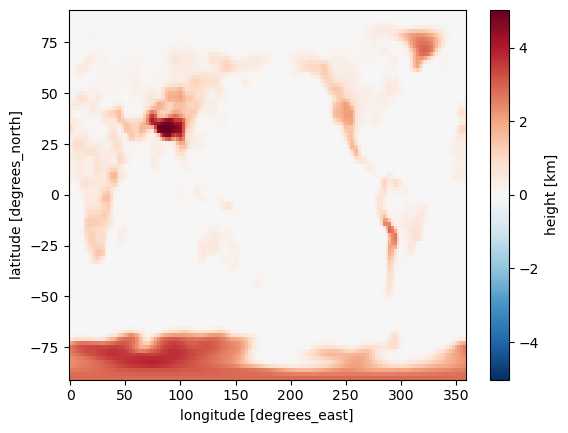

In [7]:
height.plot()

If we want more control over the appearance of the plot, we can use features of `matplotlib`

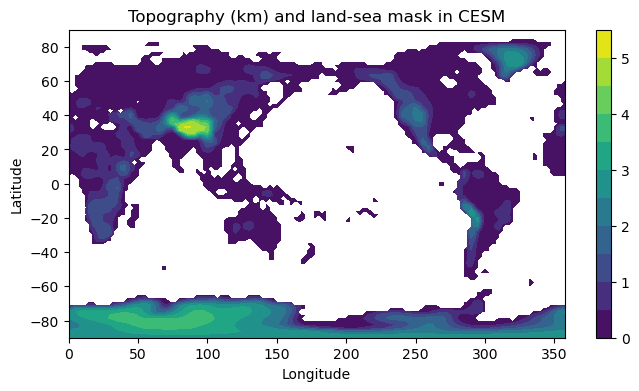

In [8]:
#  A filled contour plot of topography with contours every 500 m
lev = np.arange(0., 6., 0.5)
fig1, ax1 = plt.subplots(figsize=(8,4))
# Here we are masking the data to exclude points where the land fraction is zero (water only)
cax1 = ax1.contourf(height.lon, height.lat, 
                    height.where(topo.LANDFRAC>0),
                    levels=lev)
ax1.set_title('Topography (km) and land-sea mask in CESM')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
cbar1 = fig1.colorbar(cax1)

Note that at 2º resolution we can see many smaller features (e.g. Pacific islands). The model is given a fractional land cover for each grid point. 

Here let's plot the land-sea mask itself so we can see where there is at least "some" water:

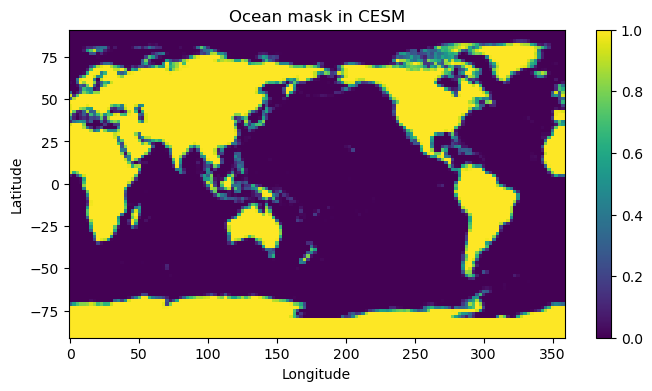

In [9]:
fig2, ax2 = plt.subplots(figsize=(8,4))
cax2 = ax2.pcolormesh( topo.lon, topo.lat, topo.LANDFRAC )
ax2.set_title('Ocean mask in CESM')
ax2.set_xlabel('Longitude'); ax2.set_ylabel('Latitude')
cbar2 = fig2.colorbar(cax2);

### Making nicer maps

Notice that to make these plots we've just plotted the lat-lon array without using any map projection.

There are nice tools available to make better maps. We'll leave that as a topic for another day. But if you're keen to read ahead, check out:

<http://scitools.org.uk/cartopy/>


## Ocean boundary conditions

Let's load another file that contains some information about the ocean and its interaction with the atmosphere.

In [10]:
som_input = xr.open_dataset( cesm_input_path + "pop_frc.1x1d.090130.nc")
som_input

<xarray.Dataset> Size: 26MB
Dimensions:  (lat: 180, lon: 360, time: 12)
Coordinates:
  * time     (time) object 96B 0001-01-15 00:00:00 ... 0001-12-16 00:00:00
Dimensions without coordinates: lat, lon
Data variables:
    area     (lat, lon) float64 518kB ...
    mask     (lat, lon) int32 259kB ...
    yc       (lat) float32 720B ...
    xc       (lon) float32 1kB ...
    S        (time, lat, lon) float32 3MB ...
    T        (time, lat, lon) float32 3MB ...
    U        (time, lat, lon) float32 3MB ...
    V        (time, lat, lon) float32 3MB ...
    dhdx     (time, lat, lon) float32 3MB ...
    dhdy     (time, lat, lon) float32 3MB ...
    hblt     (time, lat, lon) float32 3MB ...
    qdp      (time, lat, lon) float32 3MB ...
Attributes:
    creation_date:  Fri Jan 30 10:22:53 MST 2009
    comment:        This data is on a standard 1x1d grid.
    calendar:       standard
    author:         D. Bailey
    note3:          qdp is computed from depth summed ocean column
    note2:          all fields interpolated to T-grid
    note1:          fields computed from 20-yr monthly means from pop
    description:    Input data for DOCN7 mixed layer model from b40.999
    source:         pop_frc.ncl
    conventions:    CCSM data model domain description
    title:          Monthly averaged ocean forcing from POP output

The ocean / sea ice models exist on different grids than the atmosphere (1º instead of 2º resolution).

Now we are going to look at the **annual mean heat flux out of the ocean**.

It is stored in the field `qdp` in the dataset we just opened. 

The sign convention in CESM is that `qdp > 0` where heat is going **into** the ocean **from** the atmosphere. We will change the sign to plot **heat going out of the ocean into the atmosphere** (a more atmosphere-centric viewpoint). 

In [11]:
som_input.qdp

<xarray.DataArray 'qdp' (time: 12, lat: 180, lon: 360)> Size: 3MB
[777600 values with dtype=float32]
Coordinates:
  * time     (time) object 96B 0001-01-15 00:00:00 ... 0001-12-16 00:00:00
Dimensions without coordinates: lat, lon
Attributes:
    spatial_op:  Bilinear remapping: 1st order: destarea: NCL: ./map_gx1v5_to...

Unfortunately, here is a case in which the metadata are not very useful. There is no text description of what variable `qdp` actually is, or what its units are.  (It is actually in units of W m$^{-2}$)

We can see that there are 12 x 180 x 360 data points. One 180 x 360 grid for each calendar month!

Now we are going to take the average over the year at each point. 

We will use the power of `xarray` here to take the average over the time dimension, leaving us with a single grid on 180 latitude points by 360 longitude points:

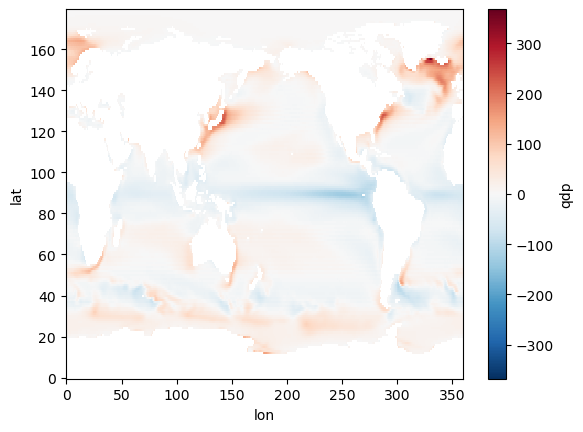

In [12]:
(-som_input.qdp.mean(dim='time')).plot()

Now make a nice plot of the annual mean q-flux. 

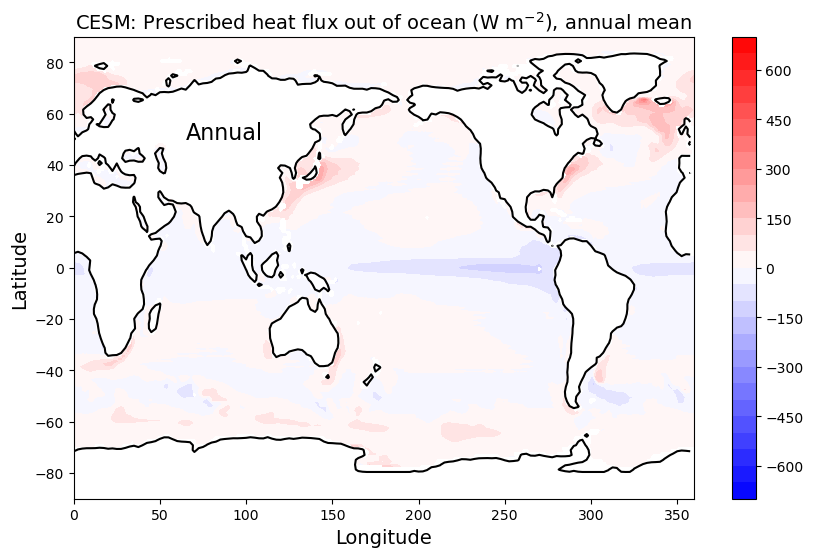

In [13]:
#  We can always set a non-standard size for our figure window
fig3, ax3 = plt.subplots(figsize=(10, 6))
lev = np.arange(-700., 750., 50.)
cax3 = ax3.contourf(som_input.xc, som_input.yc, 
                    -som_input.qdp.mean(dim='time'), 
                    levels=lev, cmap=plt.cm.bwr)
cbar3 = fig3.colorbar(cax3)
ax3.set_title( 'CESM: Prescribed heat flux out of ocean (W m$^{-2}$), annual mean', 
              fontsize=14 )
ax3.set_xlabel('Longitude', fontsize=14)
ax3.set_ylabel('Latitude', fontsize=14)
ax3.text(65, 50, 'Annual', fontsize=16 )
ax3.contour(topo.lon, topo.lat, topo.LANDFRAC, levels=[0.5], colors='k');

Notice all the spatial structure here: 

- Lots of heat is going in to the oceans at the equator, particularly in the eastern Pacific Ocean.
- The red hot spots show where lots of heat is coming out of the ocean.
- Hot spots include the mid-latitudes off the eastern coasts of Asia and North America
- And also the northern North Atlantic. 

**All this structure is determined by ocean circulation, which we are not modeling here.** Instead, we are prescribing these heat flux patterns as an input to the atmosphere.

This pattern changes throughout the year. Recall that we just averaged over all months to make this plot. We might want to look at just one month:

In [14]:
# select by month index (0 through 11)
som_input.qdp.isel(time=0)

<xarray.DataArray 'qdp' (lat: 180, lon: 360)> Size: 259kB
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-5.75126 , -5.742314, -5.734764, ..., -5.792866, -5.774798, -5.761612],
       [-5.533446, -5.537023, -5.540624, ..., -5.522859, -5.526363, -5.529893],
       [-5.31631 , -5.314115, -5.311888, ..., -5.322703, -5.320605, -5.318473]],
      shape=(180, 360), dtype=float32)
Coordinates:
    time     object 8B 0001-01-15 00:00:00
Dimensions without coordinates: lat, lon
Attributes:
    spatial_op:  Bilinear remapping: 1st order: destarea: NCL: ./map_gx1v5_to...

In [15]:
#  select by array slicing (but for this you have to know the axis order!)
som_input.qdp[0,:,:]

<xarray.DataArray 'qdp' (lat: 180, lon: 360)> Size: 259kB
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-5.75126 , -5.742314, -5.734764, ..., -5.792866, -5.774798, -5.761612],
       [-5.533446, -5.537023, -5.540624, ..., -5.522859, -5.526363, -5.529893],
       [-5.31631 , -5.314115, -5.311888, ..., -5.322703, -5.320605, -5.318473]],
      shape=(180, 360), dtype=float32)
Coordinates:
    time     object 8B 0001-01-15 00:00:00
Dimensions without coordinates: lat, lon
Attributes:
    spatial_op:  Bilinear remapping: 1st order: destarea: NCL: ./map_gx1v5_to...

Here we got just the first month (January) by specifying `[0,:,:]` after the variable name. This is called *slicing* or *indexing* an array. We are saying "give me everything for month number 0". Now make the plot:

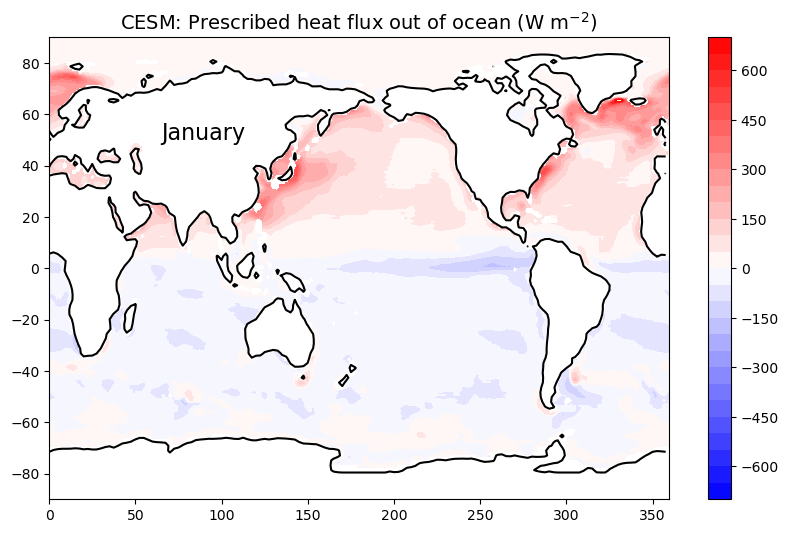

In [16]:
fig4, ax4 = plt.subplots(figsize=(10,6)) 
cax4 = ax4.contourf( som_input.xc, som_input.yc, 
                    -som_input.qdp.isel(time=0), 
                    levels=lev, cmap=plt.cm.bwr)
cbar4 = plt.colorbar(cax4)
ax4.set_title( 'CESM: Prescribed heat flux out of ocean (W m$^{-2}$)', 
              fontsize=14 )
ax3.set_xlabel('Longitude', fontsize=14)
ax3.set_ylabel('Latitude', fontsize=14)
ax4.text(65, 50, 'January', fontsize=16 );
ax4.contour(topo.lon, topo.lat, topo.LANDFRAC, levels=[0.5], colors='k');

For lots more help with using xarray to slice and dice your dataset, look at the online documentation:

http://xarray.pydata.org

## The "pre-industrial" control run

Our control run is set up to simulate the climate of the "pre-industrial era", meaning before significant human-induced changes to the composition of the atmosphere, nominally the year 1850.

Output from the control run is available on the same data server as above. Look in the folder called `cpl_1850_f19` (Here `cpl` stands for "coupled model" with interactive ocean, 1850 indicated pre-industrial conditions, and `f19` is a code for 2º the horizontal grid resolution).

There are output files for each active model component:

- atmosphere
- ocean
- sea ice
- land surface 

The model produces **monthly average** output files for each component. We can load datasets from individual months, but there are also large **concatenated** files available that contain the entire output.

Let's take a look at the atmosphere file. The file is called

`cpl_1850_f19.cam.h0.nc`

(the file extension `.nc` is used to indicate NetCDF format).

In [17]:
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc")
atm_control

<xarray.Dataset> Size: 12GB
Dimensions:       (lev: 26, ilev: 27, time: 240, lat: 96, lon: 144, slat: 95,
                   slon: 144, nbnd: 2)
Coordinates:
  * lev           (lev) float64 208B 3.545 7.389 13.97 ... 929.6 970.6 992.6
  * ilev          (ilev) float64 216B 2.194 4.895 9.882 ... 956.0 985.1 1e+03
  * time          (time) object 2kB 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
  * lat           (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon           (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * slat          (slat) float64 760B -89.05 -87.16 -85.26 ... 85.26 87.16 89.05
  * slon          (slon) float64 1kB -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
Dimensions without coordinates: nbnd
Data variables: (12/128)
    hyam          (lev) float64 208B ...
    hybm          (lev) float64 208B ...
    hyai          (ilev) float64 216B ...
    hybi          (ilev) float64 216B ...
    P0            float64 8B ...
    date          (time) int32 960B ...
    ...            ...
    VTH3d         (time, ilev, lat, lon) float32 358MB ...
    VU            (time, lev, lat, lon) float32 345MB ...
    VV            (time, lev, lat, lon) float32 345MB ...
    W2d           (time, lat, lon) float32 13MB ...
    WTH3d         (time, ilev, lat, lon) float32 358MB ...
    Z3            (time, lev, lat, lon) float32 345MB ...
Attributes: (12/16)
    Conventions:                     CF-1.0
    source:                          CAM
    case:                            cpl_1850_f19
    title:                           UNSET
    logname:                         br546577
    host:                            snow-30.rit.alba
    ...                              ...
    history:                         Tue Feb 26 17:17:15 2019: ncrcat atm/his...
    NCO:                             4.6.8
    nco_openmp_thread_number:        1
    DODS.strlen:                     8
    DODS.dimName:                    chars
    DODS_EXTRA.Unlimited_Dimension:  time

Lots of different stuff! These are all the different quantities that are calculated as part of the model simulation. **Every quantity represents a monthly average**. 

Want to get more information about a particular variable?

In [18]:
atm_control.co2vmr

<xarray.DataArray 'co2vmr' (time: 240)> Size: 2kB
[240 values with dtype=float64]
Coordinates:
  * time     (time) object 2kB 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
Attributes:
    long_name:  co2 volume mixing ratio

This is the amount of CO2 in the atmosphere (about 285 parts per million by volume). It is prescribed in these simulations and does not change.

One nice thing about `xarray.DataArray` objects is that we can do simple arithmetic with them (already seen several examples of this in the notes above). For example, change the units of CO2 amount to ppm:

In [19]:
atm_control.co2vmr * 1E6

<xarray.DataArray 'co2vmr' (time: 240)> Size: 2kB
array([284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7, 284.7, 284.7, 284.7, 284.7])
Coordinates:
  * time     (time) object 2kB 0001-02-01 00:00:00 ... 0021-01-01 00:00:00

Here's another variable:

In [20]:
atm_control.SOLIN

<xarray.DataArray 'SOLIN' (time: 240, lat: 96, lon: 144)> Size: 13MB
[3317760 values with dtype=float32]
Coordinates:
  * time     (time) object 2kB 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Solar insolation
    cell_methods:       time: mean

Apparently this is the incoming solar radiation or **insolation**, with shape (240,96,144) meaning it's got 240 months, 96 latitude points and 144 longitude points. 

___________________________
## Exercise: Taking a time average
____________________________

- Take the **time average** of the `SOLIN` field. Store the result as a new variable.
- What are the **dimensions** of the resulting data array? What would be a good way to visualize this quantity?

___________________________
## Exercise: Plotting the time average insolation
____________________________

1. Make a well-labeled plot of the time-averaged insolation (using the variable you stored above).
2. Is there a way to **further reduce the dimensionality** of the data, and plot the information in a different way?

Remember that you can apply the `.mean()` operation across any number of named dimensions in a data array.

## Comparing the control run with the observed energy budget

Recall that our investigations so far have been guided by this figure of the observed **annual, global mean energy budget**:

![Observed global energy flows from Trenberth and Fasullo (2012)](../images/GlobalEnergyBudget.png)

___________________________
## Exercise: Thinking about how to compute a global average
____________________________

In order to compare these numbers with the control run, **we need to take global averages** of the data. What do we mean by **global average**?

Before proceeding with these notes, try to answer the following question:

**Why does it not make sense to simply average over each data point on a latitude-longitude grid?**

## Weighting for global average

The global average needs to weighted by the area of each grid cell, which is proportional to the **cosine of latitude** (do you understand why?)

We can implement this in xarray as follows:

In [21]:
#  Take the cosine of latitude (first converting to radians)
coslat = np.cos(np.deg2rad(atm_control.lat))
coslat

<xarray.DataArray 'lat' (lat: 96)> Size: 768B
array([6.12323400e-17, 3.30633693e-02, 6.60905843e-02, 9.90455303e-02,
       1.31892171e-01, 1.64594590e-01, 1.97117027e-01, 2.29423920e-01,
       2.61479941e-01, 2.93250037e-01, 3.24699469e-01, 3.55793847e-01,
       3.86499169e-01, 4.16781860e-01, 4.46608807e-01, 4.75947393e-01,
       5.04765538e-01, 5.33031729e-01, 5.60715057e-01, 5.87785252e-01,
       6.14212713e-01, 6.39968541e-01, 6.65024572e-01, 6.89353409e-01,
       7.12928448e-01, 7.35723911e-01, 7.57714870e-01, 7.78877279e-01,
       7.99187997e-01, 8.18624815e-01, 8.37166478e-01, 8.54792713e-01,
       8.71484244e-01, 8.87222819e-01, 9.01991230e-01, 9.15773327e-01,
       9.28554038e-01, 9.40319390e-01, 9.51056516e-01, 9.60753676e-01,
       9.69400266e-01, 9.76986831e-01, 9.83505075e-01, 9.88947871e-01,
       9.93309266e-01, 9.96584493e-01, 9.98769969e-01, 9.99863305e-01,
       9.99863305e-01, 9.98769969e-01, 9.96584493e-01, 9.93309266e-01,
       9.88947871e-01, 9.83505075e-01, 9.76986831e-01, 9.69400266e-01,
       9.60753676e-01, 9.51056516e-01, 9.40319390e-01, 9.28554038e-01,
       9.15773327e-01, 9.01991230e-01, 8.87222819e-01, 8.71484244e-01,
       8.54792713e-01, 8.37166478e-01, 8.18624815e-01, 7.99187997e-01,
       7.78877279e-01, 7.57714870e-01, 7.35723911e-01, 7.12928448e-01,
       6.89353409e-01, 6.65024572e-01, 6.39968541e-01, 6.14212713e-01,
       5.87785252e-01, 5.60715057e-01, 5.33031729e-01, 5.04765538e-01,
       4.75947393e-01, 4.46608807e-01, 4.16781860e-01, 3.86499169e-01,
       3.55793847e-01, 3.24699469e-01, 2.93250037e-01, 2.61479941e-01,
       2.29423920e-01, 1.97117027e-01, 1.64594590e-01, 1.31892171e-01,
       9.90455303e-02, 6.60905843e-02, 3.30633693e-02, 6.12323400e-17])
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
Attributes:
    long_name:  latitude
    units:      degrees_north

In [22]:
#  And divide by its mean value
weight_factor = coslat / coslat.mean(dim='lat') 
#  Want to see what we just created?
weight_factor

<xarray.DataArray 'lat' (lat: 96)> Size: 768B
array([9.72048516e-17, 5.24872953e-02, 1.04917196e-01, 1.57232372e-01,
       2.09375617e-01, 2.61289912e-01, 3.12918491e-01, 3.64204898e-01,
       4.15093052e-01, 4.65527308e-01, 5.15452516e-01, 5.64814085e-01,
       6.13558038e-01, 6.61631075e-01, 7.08980627e-01, 7.55554920e-01,
       8.01303024e-01, 8.46174915e-01, 8.90121527e-01, 9.33094803e-01,
       9.75047755e-01, 1.01593451e+00, 1.05571035e+00, 1.09433178e+00,
       1.13175659e+00, 1.16794383e+00, 1.20285394e+00, 1.23644875e+00,
       1.26869152e+00, 1.29954700e+00, 1.32898144e+00, 1.35696266e+00,
       1.38346006e+00, 1.40844466e+00, 1.43188916e+00, 1.45376790e+00,
       1.47405697e+00, 1.49273418e+00, 1.50977911e+00, 1.52517311e+00,
       1.53889936e+00, 1.55094285e+00, 1.56129040e+00, 1.56993071e+00,
       1.57685432e+00, 1.58205366e+00, 1.58552305e+00, 1.58725870e+00,
       1.58725870e+00, 1.58552305e+00, 1.58205366e+00, 1.57685432e+00,
       1.56993071e+00, 1.56129040e+00, 1.55094285e+00, 1.53889936e+00,
       1.52517311e+00, 1.50977911e+00, 1.49273418e+00, 1.47405697e+00,
       1.45376790e+00, 1.43188916e+00, 1.40844466e+00, 1.38346006e+00,
       1.35696266e+00, 1.32898144e+00, 1.29954700e+00, 1.26869152e+00,
       1.23644875e+00, 1.20285394e+00, 1.16794383e+00, 1.13175659e+00,
       1.09433178e+00, 1.05571035e+00, 1.01593451e+00, 9.75047755e-01,
       9.33094803e-01, 8.90121527e-01, 8.46174915e-01, 8.01303024e-01,
       7.55554920e-01, 7.08980627e-01, 6.61631075e-01, 6.13558038e-01,
       5.64814085e-01, 5.15452516e-01, 4.65527308e-01, 4.15093052e-01,
       3.64204898e-01, 3.12918491e-01, 2.61289912e-01, 2.09375617e-01,
       1.57232372e-01, 1.04917196e-01, 5.24872953e-02, 9.72048516e-17])
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0

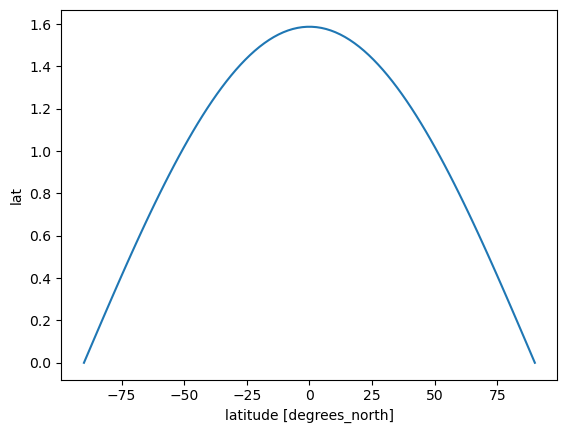

In [23]:
weight_factor.plot()

### An alternative: use weights already provided in the dataset

You will find that many gridded datasets already provide a field that gives accurate area weighting.

In the case of the CESM output, the field is called `gw`

In [24]:
weight_factor2 = atm_control.gw / atm_control.gw.mean(dim='lat')

In [25]:
weight_factor2

<xarray.DataArray 'gw' (lat: 96)> Size: 768B
array([0.00656136, 0.05248012, 0.10490285, 0.15721088, 0.209347  ,
       0.26125419, 0.31287572, 0.36415511, 0.41503631, 0.46546367,
       0.51538206, 0.56473688, 0.61347417, 0.66154063, 0.70888371,
       0.75545164, 0.80119349, 0.84605925, 0.88999985, 0.93296725,
       0.97491447, 1.01579563, 1.05556604, 1.09418219, 1.13160188,
       1.16778418, 1.20268952, 1.23627974, 1.2685181 , 1.29936936,
       1.32879977, 1.35677717, 1.38327095, 1.40825214, 1.43169343,
       1.45356918, 1.47385547, 1.49253013, 1.50957273, 1.52496463,
       1.538689  , 1.55073084, 1.56107698, 1.56971611, 1.57663877,
       1.5818374 , 1.58530632, 1.58704173, 1.58704173, 1.58530632,
       1.5818374 , 1.57663877, 1.56971611, 1.56107698, 1.55073084,
       1.538689  , 1.52496463, 1.50957273, 1.49253013, 1.47385547,
       1.45356918, 1.43169343, 1.40825214, 1.38327095, 1.35677717,
       1.32879977, 1.29936936, 1.2685181 , 1.23627974, 1.20268952,
       1.16778418, 1.13160188, 1.09418219, 1.05556604, 1.01579563,
       0.97491447, 0.93296725, 0.88999985, 0.84605925, 0.80119349,
       0.75545164, 0.70888371, 0.66154063, 0.61347417, 0.56473688,
       0.51538206, 0.46546367, 0.41503631, 0.36415511, 0.31287572,
       0.26125419, 0.209347  , 0.15721088, 0.10490285, 0.05248012,
       0.00656136])
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0

### Compute the global, time average insolation

In [26]:
#  Compute the global, time average insolation using our two different weight factors
#  Notice that we can apply the .mean() operation simultaneously over several dimensions!
print((atm_control.SOLIN * weight_factor).mean(dim=('time', 'lon', 'lat')))
print((atm_control.SOLIN * weight_factor2).mean(dim=('time', 'lon', 'lat')))

<xarray.DataArray ()> Size: 8B
array(340.32886375)
<xarray.DataArray ()> Size: 8B
array(340.30586262)


These numbers should both be very close to 340.3

This value is the global average insolation in units of W m$^{-2}$.

___________________________
## Exercise: Plotting a global average timeseries

Plot a **timeseries** of the **global average surface temperature** in the control simulation.

Surface temperature is called `'TS'` in the dataset.

Make a plot of the global average `TS` with time on the x axis. *Make sure your global average is properly weighted as discussed above.*
____________________________

### Discussion point

What do you see in this graph? Do you have any ideas about why the global average temperature looks like this?

Also, what is the **time average** global-average surface temperature in this simulation?

### Finding the radiative fluxes in the model output

Now that you can take global averages and time averages, we can compare some energy budget values against observations.

The model output contains lots of diagnostics about the radiative fluxes. Here are some CESM naming conventions to help you find the appropriate output fields:

- All variables whose names being with `'F'` are an **energy flux** of some kind. 
- Most have a four-letter code, e.g. `'FLNT'`
- `'FL'` means **longwave flux** (i.e. terrestrial)
- `'FS'` means **shortwave flux** (i.e. solar)
- The third letter indicates **direction** of the flux:
    - `'U'` = up
    - `'D'` = down
    - `'N'` = net
- The fourth letter indicates the **location** of the flux:
    - `'T'` = top of atmosphere
    - `'S'` = surface
- So `'FLNT'` means 'net longwave flux at the top of atmosphere', i.e. the outgoing longwave radiation or OLR.

You wil see that these are all 240 x 96 x 144, i.e. a two-dimensional grid for every month in the simulation.

The exception to this naming convention is, as you already saw above, that the incoming solar radiation (or insolation) is **not** called `FSDT` in the dataset but is instead called `SOLIN`.

In [27]:
atm_control.FLNT

<xarray.DataArray 'FLNT' (time: 240, lat: 96, lon: 144)> Size: 13MB
[3317760 values with dtype=float32]
Coordinates:
  * time     (time) object 2kB 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Net longwave flux at top of model
    cell_methods:       time: mean

To list all the variables in the dataset:

In [28]:
print(atm_control)

<xarray.Dataset> Size: 12GB
Dimensions:       (lev: 26, ilev: 27, time: 240, lat: 96, lon: 144, slat: 95,
                   slon: 144, nbnd: 2)
Coordinates:
  * lev           (lev) float64 208B 3.545 7.389 13.97 ... 929.6 970.6 992.6
  * ilev          (ilev) float64 216B 2.194 4.895 9.882 ... 956.0 985.1 1e+03
  * time          (time) object 2kB 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
  * lat           (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon           (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * slat          (slat) float64 760B -89.05 -87.16 -85.26 ... 85.26 87.16 89.05
  * slon          (slon) float64 1kB -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
Dimensions without coordinates: nbnd
Data variables: (12/128)
    hyam          (lev) float64 208B ...
    hybm          (lev) float64 208B ...
    hyai          (ilev) float64 216B ...
    hybi          (ilev) float64 216B ...
    P0            float64 8B ...
    date          (time) in

Okay but what if the variable I want is inside the `...`?

In [29]:
print(list(atm_control.keys()))

['hyam', 'hybm', 'hyai', 'hybi', 'P0', 'date', 'datesec', 'w_stag', 'time_bnds', 'date_written', 'time_written', 'ntrm', 'ntrn', 'ntrk', 'ndbase', 'nsbase', 'nbdate', 'nbsec', 'mdt', 'nlon', 'wnummax', 'gw', 'ndcur', 'nscur', 'co2vmr', 'ch4vmr', 'n2ovmr', 'f11vmr', 'f12vmr', 'sol_tsi', 'nsteph', 'AEROD_v', 'CLDHGH', 'CLDICE', 'CLDLIQ', 'CLDLOW', 'CLDMED', 'CLDTOT', 'CLOUD', 'CONCLD', 'DCQ', 'DTCOND', 'DTV', 'EMIS', 'FICE', 'FLDS', 'FLDSC', 'FLNS', 'FLNSC', 'FLNT', 'FLNTC', 'FLUT', 'FLUTC', 'FSDS', 'FSDSC', 'FSDTOA', 'FSNS', 'FSNSC', 'FSNT', 'FSNTC', 'FSNTOA', 'FSNTOAC', 'FSUTOA', 'ICEFRAC', 'ICIMR', 'ICWMR', 'LANDFRAC', 'LHFLX', 'LWCF', 'MSKtem', 'OCNFRAC', 'OMEGA', 'OMEGAT', 'PBLH', 'PHIS', 'PRECC', 'PRECL', 'PRECSC', 'PRECSL', 'PS', 'PSL', 'Q', 'QFLX', 'QREFHT', 'QRL', 'QRS', 'RELHUM', 'SFCLDICE', 'SFCLDLIQ', 'SHFLX', 'SNOWHICE', 'SNOWHLND', 'SOLIN', 'SWCF', 'T', 'TAUX', 'TAUY', 'TGCLDCWP', 'TGCLDIWP', 'TGCLDLWP', 'TH', 'TH2d', 'TMQ', 'TREFHT', 'TS', 'TSMN', 'TSMX', 'U', 'U10', 'U2d'

__________________________
## Exercise: Compute terms in the planetary energy budget

From the figure above of the observed energy budget, what is the value of the annual, global average absorbed solar radiation (at the top of the atmosphere)?

Which variable in the model dataset does this correspond to?

Try calculating the annual, global average ASR from the model output. Does it agree with the value given in the figure?

## A few more tidbits

Feel free to keep exploring the data!

Many other fields are four-dimensional (time, level, latitude, longitude). 

For example, here the **air temperature** at every point and every month:

In [30]:
atm_control.T

<xarray.DataArray 'T' (time: 240, lev: 26, lat: 96, lon: 144)> Size: 345MB
[86261760 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 208B 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
  * time     (time) object 2kB 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean

Often we want to sample the data **at a particular place and time**. `xarray` gives us simple ways to do that.

For example, we can **interpolate** to a particular location in latitude and longitude (here it's the coordinates of Santa Cruz, CA):

In [31]:
Tlocal = atm_control.T.interp(lat=36.97, lon=(360-122.03))
Tlocal

<xarray.DataArray 'T' (time: 240, lev: 26)> Size: 50kB
array([[232.16170593, 226.28122927, 219.31668821, ..., 277.86409219,
        280.44198102, 281.88336248],
       [233.11842465, 229.39329458, 226.1699987 , ..., 281.67863323,
        283.91147546, 284.82411114],
       [235.28632368, 229.08223745, 224.5595991 , ..., 284.55406794,
        287.22375258, 287.8637771 ],
       ...,
       [234.79764565, 230.97163021, 227.30726831, ..., 286.5089997 ,
        288.94461708, 290.18549973],
       [229.21157515, 226.25902408, 223.38734282, ..., 284.11757624,
        286.54576218, 287.59945641],
       [225.92916165, 224.37864087, 219.52827518, ..., 282.35904635,
        284.37024056, 285.17739195]], shape=(240, 26))
Coordinates:
  * lev      (lev) float64 208B 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
  * time     (time) object 2kB 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
    lat      float64 8B 36.97
    lon      float64 8B 238.0
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean

We can also use **time indexing** to pick out a particular year and month:

In [32]:
#  The .sel notation mean "select" along the given coordinate
#  The string that follows is year-month. Our simulation begins in year 0001.
Tlocal.sel(time='0020-01')  # a particular January

<xarray.DataArray 'T' (time: 1, lev: 26)> Size: 208B
array([[225.61612395, 223.81184725, 222.29371981, 219.62191608,
        216.77528004, 213.86423688, 210.6904651 , 208.36914874,
        208.81883745, 209.83606764, 210.88066435, 212.83657564,
        214.93478677, 218.09912945, 223.56534163, 230.98166666,
        239.25732823, 247.90518432, 255.97945112, 263.63254174,
        270.39125206, 275.05964195, 278.458653  , 279.9653611 ,
        282.85937328, 284.25479845]])
Coordinates:
  * lev      (lev) float64 208B 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
  * time     (time) object 8B 0020-01-01 00:00:00
    lat      float64 8B 36.97
    lon      float64 8B 238.0
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean

Now, for example, we can plot the temperature as a function of pressure at this place and time:

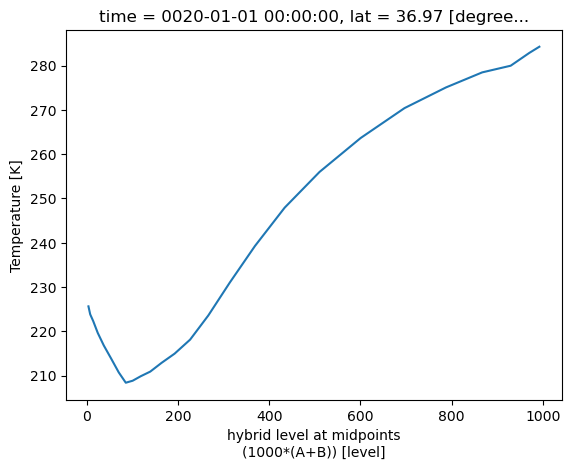

In [33]:
Tlocal.sel(time='0020-01').plot()

____________

## Credits

This notebook is part of The Climate Laboratory, an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany. It has been modified by [Nicole Feldl](http://nicolefeldl.com), UC Santa Cruz.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________